- Focus on 1D Heat only:
  - 1000 collocation points [0, 1]
    - Increasing number of layers
  - Different time interval - 
    - Difference in norms of PINN soln and actual solution: $norm(U(t+1), U(t))$
    - 0.1, 0.2....
- Video animation: interactivity

Loss = $\frac{U(t+1) - U(t)}{U(t)} * 100$

abs = 

# Experiment - Ignore

In [24]:
import torch
from torch.autograd import grad
from torch.autograd.functional import jacobian

# Define the function f
def f(x, t):
    return x**2 - t**3 + x*t
 
# Create a tensor x and set
# requires_grad=True to track the gradient
x = torch.tensor([[2.0], [1.0], [0.5]], requires_grad=True)
t = torch.tensor([[-1.0], [3.0], [0.0]], requires_grad=True)

z = f(x,t).sum()

grad_f = grad(z, (x,t), create_graph=True, allow_unused=True)
print("First order derivative: (First value is w.r.t x and then t)\n", grad_f[1])
print("---------------")

out = torch.empty([3, 1])
grad_grad_fx = grad([grad_f[0][i] for i in range(3)], inputs=(x,t), create_graph=True, allow_unused=True)
# print("HERE", grad_grad_fx)

for i in range(3):
    grad_grad_fx = grad(grad_f[0][i], inputs=(x,t), create_graph=True, allow_unused=True)
    # print("Second order derivative w.r.t x: (First value is w.r.t x and then t)\n", [x[i] for x in grad_grad_fx][0])
    grad_grad_ft = grad(grad_f[1][i], inputs=(x,t), create_graph=True, allow_unused=True)
    # print("Second order derivative w.r.t t: (First value is w.r.t x and then t)\n", [x[i] for x in grad_grad_ft][1])
    # print([x[i] for x in grad_grad_ft][1] - [x[i] for x in grad_grad_fx][0])
    out[i] = [x[i] for x in grad_grad_ft][1] - 4*[x[i] for x in grad_grad_fx][0]

print(out)
# print(out.shape)


First order derivative: (First value is w.r.t x and then t)
 tensor([[ -1.0000],
        [-26.0000],
        [  0.5000]], grad_fn=<AddBackward0>)
---------------
tensor([[ -2.],
        [-26.],
        [ -8.]], grad_fn=<CopySlices>)


In [25]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.autograd import grad
import matplotlib.pyplot as plt

import numpy as np

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

import matplotlib.pyplot as plt
"""
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

"""


"\n# Device configuration\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\nprint(device)\n\nif device == 'cuda':\n    print(torch.cuda.get_device_name())\n\n"

## Equations at hand

||Equation|
|-|-|
|Differential equation|$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = \frac{\partial^2 u}{\partial t^2}$|
|Analytical solution||
|Dirichlet BCs|$u(0,y,t) = 0$|
||$u(\pi,y,t) = 0$|
||$u(x,0,t) = 0$|
||$u(x,\pi,t) = 0$|
|Initial conditions|$u(x,y,0) = 0$|
||$\frac{\partial u}{\partial t}(x,y,0) = x(\pi - x)sin3y$|

## Needed funcs

In [26]:
def analytic_solution(point):
    x,y,t = point
    return torch.sin(torch.pi*x)*torch.sin(2*torch.pi*y)*torch.cos(torch.pi*2.23*t)

def rhs_of_differential_equation(point):
    return torch.Tensor([0])

## NN class

In [27]:
class FCN(nn.Module):
    ##  Neural Network
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class
        self.flatten = nn.Flatten()
        self.loss_function = nn.MSELoss(reduction ='mean')
        # Adding number of layers as in `layers` variable from control
        self.layers = nn.Sequential()
        # All layers from 0 to layers-1
        for i in range(len(layers[:-1])):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            self.layers.append(nn.Tanh())
        # last layer
        self.layers.append(nn.Linear(layers[-1], 1))
        
    def forward(self, point):
        nn_input = torch.hstack(point)
        nn_output = self.layers(nn_input)
        return nn_output

    def trial_eqn(self, point):
        return self.forward(point)
    
    def loss_pde(self, point):
        z = self.trial_eqn(point).sum()
        grad_trial_eqn = grad(z, point, create_graph=True, allow_unused=True)
        
        ##############################################
        dff_psi = torch.empty([point[0].shape[0], 1])
        for i in range(point[0].shape[0]):
            grad_grad_fx = grad(grad_trial_eqn[0][i], inputs=point, create_graph=True, allow_unused=True)
            grad_grad_fy = grad(grad_trial_eqn[1][i], inputs=point, create_graph=True, allow_unused=True)
            grad_grad_ft = grad(grad_trial_eqn[2][i], inputs=point, create_graph=True, allow_unused=True)
            
            dff_psi[i] = [x[i] for x in grad_grad_fx][0] + [y[i] for y in grad_grad_fy][1] - [t[i] for t in grad_grad_ft][2]
            
        ##############################################
        
        expected_output = rhs_of_differential_equation(point)
        return self.loss_function(dff_psi, expected_output)
    
    def loss_bc(self, point):
        x, y, t = point
        zeros = torch.zeros(x.shape[0],1, requires_grad=True)
        ones = torch.ones(x.shape[0],1,requires_grad=True)
        pi = torch.tensor([torch.pi]*x.shape[0]).reshape(x.shape[0],1)
        
        z_for_loss = self.trial_eqn((x, y, zeros)).sum()
        grad_f_for_loss = grad(z_for_loss, (x,y,zeros), create_graph=True, allow_unused=True)[0]

        initial_cond_loss1 = self.loss_function(self.trial_eqn((x,y,zeros)), zeros)
        initial_cond_loss2 = self.loss_function(grad_f_for_loss, x*(torch.pi-x)*torch.sin(3*y))
        loss1 = self.loss_function(self.trial_eqn((zeros, y, t)), zeros)
        loss2 = self.loss_function(self.trial_eqn((pi, y, t)), zeros)
        loss3 = self.loss_function(self.trial_eqn((x, zeros, t)), zeros)
        loss4 = self.loss_function(self.trial_eqn((x, pi, t)), zeros)
        
                
        return (loss1+loss2+loss3+loss4+initial_cond_loss1+initial_cond_loss2)
        
    def loss_new_appoach(self, point):
        pde_loss = self.loss_pde(point)
        bc_loss = self.loss_bc(point)
        
        return pde_loss + bc_loss

# Generate data

In [31]:
steps = 5000
lr = 0.02
layers = np.array([3, 64, 64]) # layers

# To generate new data:
x_min = 0
x_max = torch.pi
y_min = 0
y_max = torch.pi
t_min = 0
t_max = 1

total_points = 10

In [32]:
X_ = torch.linspace(x_min, x_max, total_points, requires_grad=True).view(-1,1)
Y_ = torch.linspace(y_min, y_max, total_points, requires_grad=True).view(-1,1)
T_ = torch.linspace(t_min, t_max, total_points, requires_grad=True).view(-1,1)

X, T, Y = torch.meshgrid(X_.squeeze(1), Y_.squeeze(1), T_.squeeze(1))

print(f"Generating {total_points} of x,y and t")
print(f"Shape of generated data: {X.shape}")

Generating 10 of x,y and t
Shape of generated data: torch.Size([10, 10, 10])


# Model training and eval

In [33]:
#Create Model
PINN = FCN(layers)
optimizer = torch.optim.SGD(PINN.parameters(), lr=lr)

In [34]:
PINN

FCN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (loss_function): MSELoss()
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [56]:
def plotter(axes, x, y):
    ax = plt.axes(projection='3d')
    for i in range(len(axes[0])):
        ax.plot_surface(axes[0][:,:,i], axes[1][:,:,i], axes[2][:,:,i], cmap="rainbow")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()
    
    ax = plt.axes(projection='3d')
    for i in range(len(axes[0])):
        ax.plot_surface(axes[1][:,:,i], axes[0][:,:,i], axes[2][:,:,i], cmap="rainbow")
    ax.set_xlabel(y)
    ax.set_ylabel(x)
    plt.show()
    
def plot3d(dim1, dim2, output):
    '''
    dim1 : n, m
    dim2: n, m
    output: n, m
    '''
    '''
    Plot all together
    '''
    axes = [item if not isinstance(item, torch.Tensor) else item.detach().numpy() for item in [dim1, dim2, output]]
    plotter(axes, 'x', 'y')

In [57]:
true_psi = analytic_solution((X, Y, T))    # (n, n)

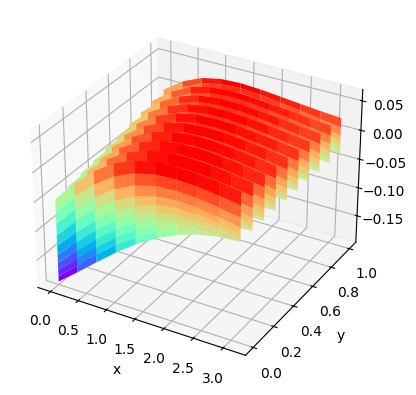

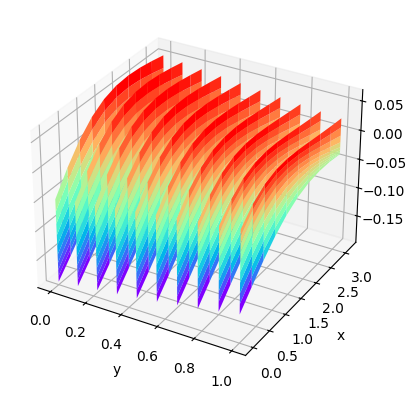

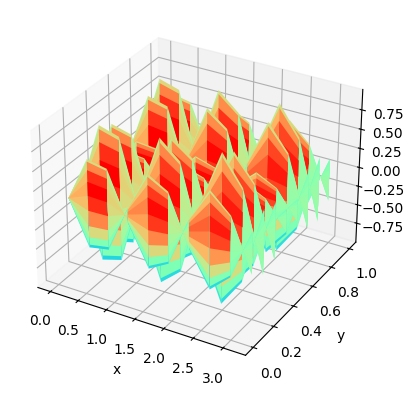

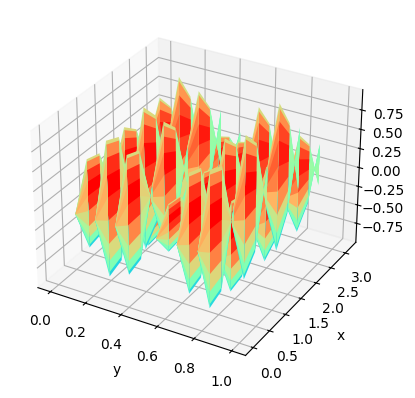

In [58]:
input_X, input_Y, input_T = X.transpose(1,0).flatten()[:,None], Y.transpose(1,0).flatten()[:,None], T.transpose(1,0).flatten()[:,None]   # Both (n*n, 1)
initial_model_output = PINN.trial_eqn((input_X, input_Y, input_T))     # (n*n, 1)
initial_model_output = initial_model_output.reshape(shape=[total_points, total_points, total_points]).transpose(1,0) # Reshaped to (n,n)

plot3d(X, Y, initial_model_output)  # (n,n)(n,n)(n,n)
plot3d(X, Y, true_psi)  # (n,n)(n,n)(n,n)

In [55]:
PINN.train()
for i in range(steps):
    if i==0:
        print("Training Loss")
    loss = PINN.loss_new_appoach((X_, Y_, T_))
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    
    if i%(steps//20) == 0:
        print(i, loss.detach().cpu().numpy())

Training Loss
0 1.8208532


c:\Users\varun\.conda\envs\nn_de\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

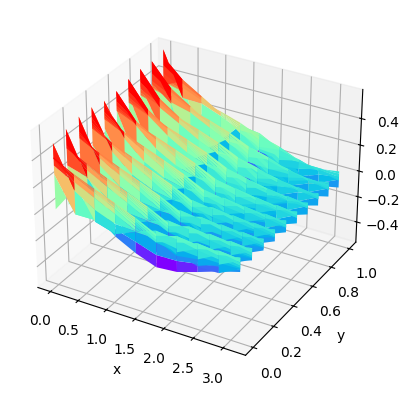

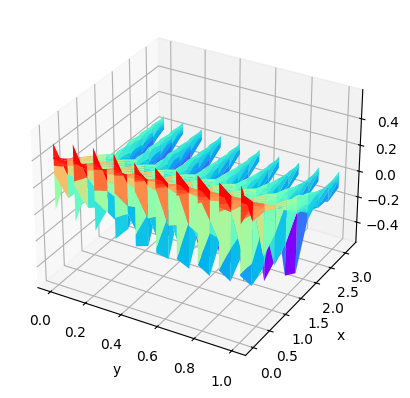

In [15]:
input_X, input_Y, input_T = X.transpose(1,0).flatten()[:,None], Y.transpose(1,0).flatten()[:,None], T.transpose(1,0).flatten()[:,None]   # Both (n*n, 1)
final_model_output = PINN.trial_eqn((input_X, input_Y, input_T)) 
final_model_output = final_model_output.reshape(shape=[total_points, total_points, total_points]).transpose(1,0) # Reshaped to (n,n)

plot3d(X, Y, final_model_output)

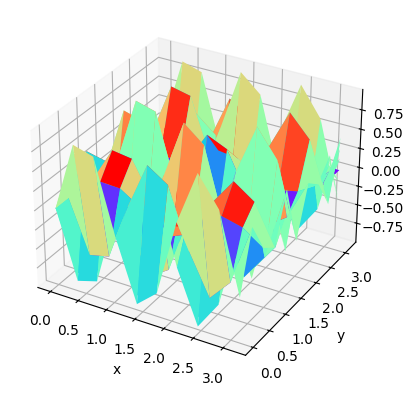

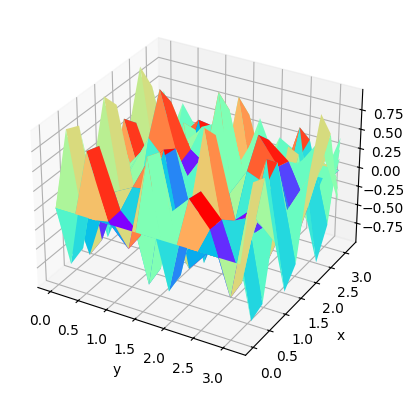

In [23]:
plot3d(X, T, true_psi)